In [1]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
from torch import optim

import torch 
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint
from torch.distributions.uniform import Uniform


import pandas as pd


In [2]:
# generate the dataset first
def Batch(t,y,qsmax,Ks,a,ms):
    Cs,Cx=y
    if Cs<0:
        Cs=0
    #Kinetic equations
    qs=qsmax*(Cs/(Ks+Cs))
    qx=(qs-ms)/a
    #Rate equations
    Rs=qs*Cx*1
    Rx=qx*Cx*1
    #Rc=-(Rs+Rx)  #Rco2 and Ro2
    R=[Rs,Rx]
    return R


qsmax=-0.3 #CmolS.Cmolx-1.h_1
Ks=0.01 #Cmol.S.L-1
a= -1.6 #S requirement for biomass
ms=-0.01 #CmolS.Cmolx-1.h-1



#Initial conditions
Cs=3 #Cmol.L-1
Cx=0.01 #Cmol.L-1
Vl=1

def Batch(t,y,qsmax,Ks,a,ms):
    Cs,Cx=y
    if Cs<0:
        Cs=0
    #Kinetic equations
    qs=qsmax*(Cs/(Ks+Cs))
    qx=(qs-ms)/a
    #Rate equations
    Rs=qs*Cx*1
    Rx=qx*Cx*1
    #Rc=-(Rs+Rx)  #Rco2 and Ro2
    R=[Rs,Rx]
    return R

t = np.linspace(0, 50, 20)
sol = solve_ivp(Batch, [0, 50], [3, 0.01], args=(qsmax,Ks,a,ms),t_eval=t,method="LSODA")

In [3]:
np.shape(sol.t)

(20,)

In [4]:
# sol.t

dataset=pd.DataFrame(sol.y,columns=sol.t,index=["glucose","biomass"])

dataset.to_csv("Batch Bioprocess/rawdata_batch_bioprocess.csv",)

OSError: Cannot save file into a non-existent directory: 'Batch Bioprocess'

In [33]:

    

class Bioprocess(nn.Module):
    """ 
    Batch Bioprocess. # parameter_dictionary
    """
    def __init__(self, 
                 parameter_dict
                 ):
        super().__init__() 
        self.qsmax = torch.nn.Parameter(torch.tensor(parameter_dict['qsmax'])) # make mu a learnable parameter
        self.Ks = torch.nn.Parameter(torch.tensor(parameter_dict['Ks']))
        self.a = torch.nn.Parameter(torch.tensor(parameter_dict['a']))
        self.ms = torch.nn.Parameter(torch.tensor(parameter_dict['ms']))
        
    def forward(self, 
                t: float, # time index
                state:torch.TensorType, # state of the system first dimension is the batch size
                ) -> torch.Tensor: # return the derivative of the state
        """ 
            Define the right hand side of the VDP oscillator.
        """
        Cs=state[0]
        Cx=state[1]
        
        if Cs<0:
            Cs=0
        #Kinetic equations
        qs=self.qsmax*(Cs/(self.Ks+Cs))
        qx=(qs-self.ms)/self.a

        #Rate equations
        Rs=qs*Cx*1
        Rx=qx*Cx*1
        #Rc=-(Rs+Rx)  #Rco2 and Ro2


        return torch.Tensor([Rs,Rx])
    
    def __repr__(self):
        """Print the parameters of the model."""
        return f" qsmax: {self.qsmax.item()}, a:{self.a.item()}, ms:{self.ms.item()}, Ks:{self.Ks.item()}"

    



In [38]:
param1=float(Uniform(-0.5,-0.1).sample((1,)))
param2=float(Uniform(0.000,0.1).sample((1,)))        
param3=float(Uniform(-1.8,-1.40).sample((1,)))
param4=float(Uniform(-0.1,0.100).sample((1,)))   
parameter_dict={"qsmax":param1,"Ks":param2,"a":param3,"ms":param4}

worker_ode=Bioprocess(parameter_dict)

tensor_timestamps = torch.linspace(0,100,20)


tensor_concentrations=torch.tensor(sol.y, dtype=torch.float64, requires_grad=False)
rows,cols=np.shape(tensor_concentrations)
tensor_concentrations=torch.reshape(tensor_concentrations,shape=(1,rows,cols))
predicted_c = odeint(func=worker_ode, y0=tensor_concentrations[0][:,0], t=tensor_timestamps,method="scipy_solver",options={"solver":"LSODA"})

# tensor_concentrations[0][:,0]


In [41]:
predicted_c

tensor([[3.0000e+00, 1.0000e-02],
        [2.9913e+00, 1.3003e-02],
        [2.9800e+00, 1.6907e-02],
        [2.9652e+00, 2.1982e-02],
        [2.9461e+00, 2.8579e-02],
        [2.9212e+00, 3.7153e-02],
        [2.8889e+00, 4.8294e-02],
        [2.8468e+00, 6.2767e-02],
        [2.7922e+00, 8.1563e-02],
        [2.7214e+00, 1.0596e-01],
        [2.6293e+00, 1.3761e-01],
        [2.5100e+00, 1.7863e-01],
        [2.3554e+00, 2.3172e-01],
        [2.1554e+00, 3.0029e-01],
        [1.8974e+00, 3.8856e-01],
        [1.5658e+00, 5.0150e-01],
        [1.1438e+00, 6.4416e-01],
        [6.1985e-01, 8.1764e-01],
        [7.1317e-02, 9.7469e-01],
        [9.4907e-06, 8.5538e-01]], dtype=torch.float64,
       grad_fn=<OdeintAdjointMethodBackward>)

In [16]:
tensor_concentrations[0][:,0]

tensor([3.0000, 0.0100], dtype=torch.float64)

In [5]:
device=torch.device('cpu')

param1=float(Uniform(-0.5,-0.1).sample((1,)))
param2=float(Uniform(0.000,0.1).sample((1,)))        
param3=float(Uniform(-1.8,-1.40).sample((1,)))
param4=float(Uniform(-0.1,0.100).sample((1,)))   
parameter_dict={"qsmax":param1,"Ks":param2,"a":param3,"ms":param4}

worker_ode=Bioprocess(parameter_dict)



tensor_timestamps = torch.linspace(0,50,20)


tensor_concentrations=torch.tensor(sol.y, dtype=torch.float64, requires_grad=False)
rows,cols=np.shape(tensor_concentrations)
tensor_concentrations=torch.reshape(tensor_concentrations,shape=(1,rows,cols))





def loss_func():
    tensor_c0=tensor_concentrations[0][:,0]  
    tensor_c0=tensor_c0.reshape(shape=(1,2))

    #target dataset
    target=tensor_concentrations[0].T

    #predicted dataset
    predicted_c = odeint(func=worker_ode, y0=tensor_c0, t=tensor_timestamps,method="scipy_solver",options={"solver":"LSODA"})
    predicted_c=predicted_c[:,0,:]
    ls =torch.mean(torch.square((predicted_c - target)))
    return ls




NameError: name 'Bioprocess' is not defined

In [32]:
np.shape(tensor_concentrations) #1,2,20
np.shape(tensor_c0)

NameError: name 'tensor_c0' is not defined

In [5]:




get_loss_per_iteration=[]
qsmax_per_iteration=[]
a_per_iteration=[]
Ks_per_iteration=[]
ms_per_iteration=[]


## Minimize loss

In [8]:
optimizer=optim.AdamW(worker_ode.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=20)






for i in range(0,100,1):

    scheduler_step=True
    optimizer.zero_grad()
    loss = loss_func()
    print(loss)
    
    get_loss_per_iteration.append(loss.detach().numpy())
    loss.backward()
    optimizer.step()
    # print(loss.backward())
    if scheduler_step:
        scheduler.step(loss)

    for name,param in worker_ode.named_parameters():
        if name=="a":
            a_per_iteration.append(param.clone().detach().numpy())
        elif name=="Ks":
            Ks_per_iteration.append(param.clone().detach().numpy())
        elif name=="ms":
            ms_per_iteration.append(param.clone().detach().numpy())
        elif name=="qsmax":
            qsmax_per_iteration.append(param.clone().detach().numpy())



tensor(0.0004, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0006, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0004, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0005, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0006, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0005, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0004, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0004, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0004, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0004, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0004, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0003, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0003, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0004, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0004, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0004, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0003, dtype=tor

Text(0, 0.5, 'Parameter value')

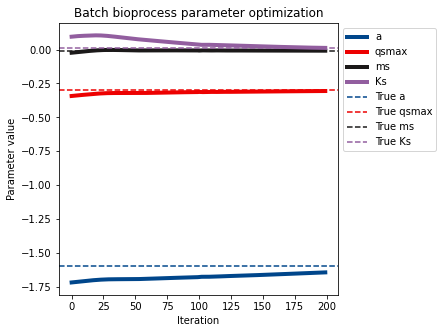

In [9]:
fig,ax=plt.subplots(figsize=(5,5))
plt.title("Batch bioprocess parameter optimization")
plt.plot(a_per_iteration, label="a",c="#00468BFF",linewidth=4)
plt.plot(qsmax_per_iteration,label="qsmax",c="#ED0000FF",linewidth=4)
plt.plot(ms_per_iteration,label="ms",c="#1B1919FF",linewidth=4)
plt.plot(Ks_per_iteration,label="Ks",c="#925E9FFF",linewidth=4)

plt.axhline(-1.6,label="True a",c="#00468BFF",linestyle="--")
plt.axhline(-0.3,label="True qsmax",c="#ED0000FF",linestyle="--")
plt.axhline(-0.01,label="True ms",c="#1B1919FF",linestyle="--")
plt.axhline(0.01,label="True Ks",c="#925E9FFF",linestyle="--")

plt.yscale("linear")

ax.legend(bbox_to_anchor=(1,1))
plt.xlabel("Iteration")
plt.ylabel("Parameter value")

Text(0, 0.5, 'Loss')

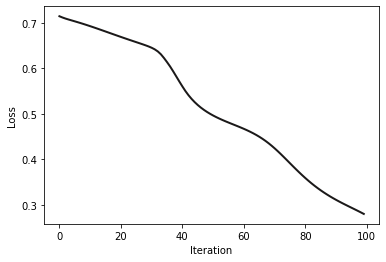

In [14]:
plt.plot(get_loss_per_iteration[0:100],c="#1B1919FF",linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Loss")

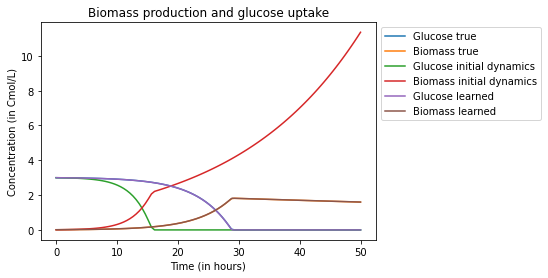

In [21]:
# TRUE DYnamics

qsmax=-0.3 #CmolS.Cmolx-1.h_1
Ks=0.01 #Cmol.S.L-1
a= -1.6 #S requirement for biomass
ms=-0.01 #CmolS.Cmolx-1.h-1


#Initial conditions
Cs=3 #Cmol.L-1
Cx=0.01 #Cmol.L-1
Vl=1



t = np.linspace(0, 50, 100)
sol = solve_ivp(Batch, [0, 50], [3, 0.01], args=(qsmax,Ks,a,ms),t_eval=t,method="LSODA")
    

z = sol.y.T

plt.plot(t,z[:,0],label="Glucose true")
plt.plot(t,z[:,1],label="Biomass true")
plt.xlabel("Time (in hours)")
plt.ylabel("Concentration (in Cmol/L)")
plt.title("Biomass production and glucose uptake")          
plt.legend()
# plt.show()

#initial dynamics
qsmax=param1 #CmolS.Cmolx-1.h_1
Ks=param2 #Cmol.S.L-1
a= param3 #S requirement for biomass
ms=param4 #CmolS.Cmolx-1.h-1


t = np.linspace(0, 50, 100)
sol_init = solve_ivp(Batch, [0, 50], [3, 0.01], args=(qsmax,Ks,a,ms),t_eval=t,method="LSODA")
    
z2 = sol_init.y.T
plt.plot(t,z2[:,0],label="Glucose initial dynamics")
plt.plot(t,z2[:,1],label="Biomass initial dynamics")
plt.xlabel("Time (in hours)")
plt.ylabel("Concentration (in Cmol/L)")
plt.title("Biomass production and glucose uptake")          
plt.legend()

#learned dynamics








#learned dynamics

qsmax=optimizer.param_groups[0]['params'][0].detach().numpy()
Ks=optimizer.param_groups[0]['params'][1].detach().numpy()
a= optimizer.param_groups[0]['params'][2].detach().numpy()
ms=optimizer.param_groups[0]['params'][3].detach().numpy()

t = np.linspace(0, 50, 1000)
sol_learned = solve_ivp(Batch, [0, 50], [3.0, 0.01], args=(qsmax,Ks,a,ms),t_eval=t,method="LSODA")
# print(optimizer.param_groups)

z3 = sol_learned.y.T


plt.plot(t,z3[:,0],label="Glucose learned")
plt.plot(t,z3[:,1],label="Biomass learned")
plt.xlabel("Time (in hours)")
plt.ylabel("Concentration (in Cmol/L)")
plt.title("Biomass production and glucose uptake") 

plt.legend(bbox_to_anchor=(1,1))
# plt.show()


In [ ]:
qsmax

array(-0.29924336, dtype=float32)